# Yelp Data Challenge - Restaurant Recommender

A recommender system is the crux of many data-driven businesses, such as Youtube, Facebook and of course Yelp. Here we will attempt to build a simple system recommending restaurants in Las Vegas. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [2]:
df = pd.read_csv('data/last_2_years_restaurant_reviews.csv')
df.head(3)

,business_id,name,categories,avg_stars,attributes,cool,date,funny,review_id,stars,text,useful,user_id
0,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,"Restaurants, Pizza",2.5,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",0,2017-04-01,0,Spl0fx_X6bjPASU-zUJQUA,1,"Ordered a pizza, the location is literally in ...",1,vZ-eQzpCOrSWfBfU5KUvIA
1,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,"Restaurants, Pizza",2.5,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",0,2016-11-20,0,2UV-a8pXUdbK0fdurFwXfQ,5,Very busy place but they take good care of you...,0,nu6wU6PLbL9HPLZuqon0-A
2,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,"Restaurants, Pizza",2.5,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",0,2018-03-27,0,vG5m3TzOf5F52jzO2D_19g,3,Stopped here to pick up an order of wings on m...,0,KEerqlFNhzl1I-yVK6mHVA


## 1) Build two versions of the utility matrix, and compare recommender performance

1. Vanilla version: use *only* the explicit star rating of each review
2. Explicit star rating, weighted by the number of 'useful' tags of each review. If review receives receives more than [ threshold ] useful tags, depress or increase rating by 0.5.

### First, collect all relevant data into one place

In [3]:
# Get business_id, user_id, stars, useful for recommender
# Getting name and categories as well, for verifying recommender later
df_recommender = df.loc[:, ["business_id", "user_id", "stars", "name", "categories", 'useful']]

In [4]:
# Confirm there are no NAs
pd.DataFrame.sum(df_recommender.isna())

business_id    0
user_id        0
stars          0
name           0
categories     0
useful         0
dtype: int64

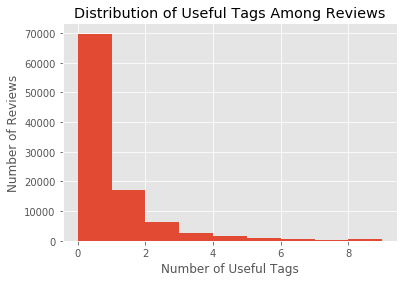

In [5]:
# Visualize the number of 'useful' tags per review
# The vast majority of reviews received less than 2 
plt.xlabel("Number of Useful Tags")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Useful Tags Among Reviews")
df.useful.hist(bins=range(10))

In [6]:
# Total number of reviews
print( df_recommender.shape[0] )

# Confirming: number of reviews with 2 tags or more: ~10-15%. A minority.
print( (df_recommender.useful >= 2).sum() )

101569
14692


In [7]:
# Engineer new feature: weighted_stars
def construct_weighted_stars(row, threshold):
    ''' 
        row: Pandas Series containing each row of data
        threshold: the number of useful tags required for executing the weighting 
    '''
    
    if row.useful >= threshold:
        star = row.stars
        useful = row.useful
    
        if star > 3:
            return (star + 0.5)
        elif star == 3:
            return star
        else:
            return (star - 0.5)
    else:
        return row.stars
        
weighted_stars = df_recommender.apply(construct_weighted_stars, args=(2,), axis=1)
df_recommender['weighted_stars'] = weighted_stars

In [8]:
# Verify results
df_recommender.loc[:, ['useful', 'stars', 'weighted_stars']].head(5)

,useful,stars,weighted_stars
0,1,1,1.0
1,0,5,5.0
2,0,3,3.0
3,2,1,0.5
4,0,1,1.0


### Exclude users who haven't given many reviews

Goal: to avoid pigenholing and poor performance due to *cold starts*. 

If this were a production system, we could ask new users to specify several types of preferred restaurants, and build an additional, content-based recommendation system based on their responses. That should allow us to work around cold starts.

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  29  30  32  34  35  36  45  47  57
 113]


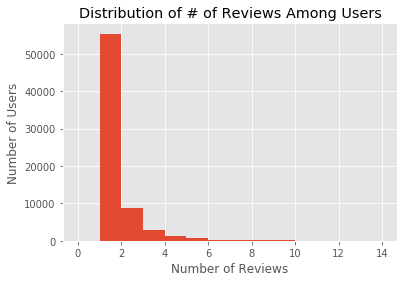

In [9]:
# Count the number of occurences of each user_id, and print
# Need to see actual distribution to decide cutoff!
review_count_by_user = df_recommender['user_id'].value_counts(ascending=True)

plt.title("Distribution of # of Reviews Among Users")
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Users")
review_count_by_user.hist(bins=range(0,15))

print( review_count_by_user.unique() )

In [10]:
# Only ~3100 out of 69985 users will get recommendations
# Increase any further,
threshold = 4
few_reviews_mask = (review_count_by_user < threshold)
print( "{} users out of {} have less than {} reviews".format(few_reviews_mask.sum(), 
                                                             len(few_reviews_mask),
                                                             threshold
                                                            ) ) 

66828 users out of 69985 have less than 4 reviews


In [11]:
users_with_few_reviews = review_count_by_user[ few_reviews_mask ].index

In [12]:
# Set 'user_id' as index, and drop rows whose index is in users_with_few_reviews
print(df_recommender.shape)
df_recommender = df_recommender.set_index('user_id')
print(df_recommender.shape)
df_recommender = df_recommender.drop(index=users_with_few_reviews)
print(df_recommender.shape)

(101569, 7)
(101569, 6)
(20518, 6)


In [13]:
# Reset index to obtain "normal" DF again
df_recommender = df_recommender.reset_index()

In [14]:
# Verify results: now users have at least [threshold] reviews
df_recommender['user_id'].value_counts(ascending=True).head(5)

07UWbgojyCyyQMIRgplw3Q    4
OhEe7BHJHoMDPbDE2aHO9Q    4
DVzoOLn-dwXQMV78H8p3XQ    4
7cgp0EXG11v-y4F6sDU1hg    4
3Hn5PexeY0tir0uFWk4jJg    4
Name: user_id, dtype: int64

In [15]:
df_recommender.shape

(20518, 7)

#### Create utility matrix from records

Here we can use either `stars` or `weighted_stars` as our rating feature. In a production syste, it'd be up to A/B testing to decide which formulation leads to better predictions (recommendations). For instance for each user, we can measure whether he/she actually click on or even visit in person the top `K` recommendations. This can be thought of as binary classification problem, and we can compare the AUCs of the two utility matrix formulations.

For this notebook, we will stick with `stars`, and create the utility matrix `U_simple`.

In [16]:
U_simple = pd.pivot_table(data = df_recommender,
                          values = 'stars',
                          index = 'user_id',
                          columns = 'business_id',
                          fill_value = 0.0)

# U_weighted = pd.pivot_table(data = df_recommender,
#                             values = 'weighted_stars',
#                             index = 'user_id',
#                             columns = 'business_id',
#                             fill_value = 0.0)

## 2) Build Recommendation Systems

### Item-Item Collaborative Filtering

Implemented in `Recommender.py`, as the Python class ItemItemRecommender. We will utilize `sample_user` as an example to demonstrate the recommendations, where `sample_user` is an integer index into the rows of the utility matrix.

In [17]:
from Recommender import ItemItemRecommender

In [18]:
sample_user = 1100

my_rec_engine = ItemItemRecommender(neighborhood_size=75)
my_rec_engine.fit(U_simple.values)
user_preds = my_rec_engine.pred_one_user(user_id=sample_user, report_run_time=True)

# Show predicted ratings for user #0 on first 100 items
print(user_preds[:50])

Execution time: 0.019768 seconds
[0.         0.         0.         3.54627964 5.         0.
 4.         4.         3.99989156 0.         0.         0.
 0.         0.         0.         3.49831952 4.28813408 3.42212598
 0.         0.         4.41327969 3.67297498 0.         3.
 0.         3.82330144 0.         0.         0.         0.
 0.         0.         4.44663121 3.         0.         3.
 4.         3.56222289 4.         0.         0.         4.
 0.         4.         0.         0.         0.         4.14340954
 0.         0.        ]


/Volumes/HardDisk/BitTiger-YelpDataChallenge/Recommender.py:38: RuntimeWarning: invalid value encountered in double_scalars
  self.item_sim_mat[item_to_rate, relevant_items].sum()


### See if the recommendations make any sense at all

In [19]:
from Recommender import displayHelper

In [20]:
# Import data describing restaurants in Las Vegas
business_info = pd.read_csv("data/selected_business.csv").set_index("business_id")

# Obtain business_id's of top N recommended restaurants 
recommended_restaurants = displayHelper(sample_user, user_preds, U_simple, N=5)

# Print top N recommended restaurants
business_info.loc[ recommended_restaurants , ["name", "categories", "attributes"]]

,name,categories,attributes
business_id,,,
BbOx9i_kDJBnE9K2hyqBTg,Kahuku Poke and Hawaiian Barbecue,"Restaurants, Poke, Specialty Food, Hawaiian, F...","{'Alcohol': 'none', 'Ambience': ""{'romantic': ..."
dKdApYVFDSNYsNOso6NYlA,White Castle,"Restaurants, Fast Food, Breakfast & Brunch, Bu...","{'Alcohol': 'beer_and_wine', 'Ambience': ""{'ro..."
Ta4GRuHyZvU5H_l5IAG1PQ,Nanay Gloria,"Restaurants, Buffets, Fast Food, Filipino","{'Alcohol': 'none', 'Ambience': ""{'romantic': ..."
t6ZIBNrQjvtwor8W-u3sUg,Chop Chop Wok,"Restaurants, Japanese, Chinese","{'Alcohol': 'none', 'Ambience': ""{'romantic': ..."
tIRn9YlrJ4Y5IyHzY72i9A,Subway,"Restaurants, Fast Food, Sandwiches","{'Alcohol': 'none', 'Ambience': ""{'romantic': ..."


In [21]:
print("Here are the restaurants reviewed")
sample_uid = U_simple.index[sample_user]
df_recommender.loc[df_recommender["user_id"] == sample_uid, ["name", "categories", "stars"]]

Here are the restaurants reviewed


,name,categories,stars
4054,Fausto's Mexican Grill,"Restaurants, Breakfast & Brunch, Mexican, Chic...",4
9211,Sapporo Revolving Sushi,"Restaurants, Conveyor Belt Sushi, Seafood, Jap...",4
11109,Honey Salt,"Restaurants, American (New), Cafes",3
15347,Asian BBQ & Noodle,"Restaurants, Chinese, Noodles, Barbeque",5


### Observations for Item-Item Collaborative Filtering
The top 5 recommended restaurants has **some** overlap in categories, e.g. Japanese/sushi, breakfast, with the reviewed restaurants. This makes sense --- after all, users are likely to keep eating the same kind of food that they enjoyed.

#### Potential improvement 
We haven't made use of the detailed attributes of each restaurant; notice how most restaurants reviewed above provide alcohol, but the recommended ones don't. Potentially, we can segment the restaurants according to attributes, build separate recommendation systems for each, and make suggestions based on some finer-grained model of user preference.

## 3. Matrix Factorization Recommender
Non-Negative Matrix Factorization (NMF) has become a popular way to implement recommendation systems in the recent years. Let's try that out.

After some research, I am settling on using the [NMF implementation](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.NMF) by [scikit-surprise](http://surpriselib.com/). It possesses a `scikit-learn`-like interface, which makes it easy to use, while providing a wider array of functionalities than its API cousin. In particular, it can take into account item and user biases out-of-the-box! 

(Imagine how there are users who tend to give harsher ratings than other people. Sometimes it's not that they really dislike an item; rather, it's just that they never give perfect ratings --- 5 in our present case. This is what we meant by (user) bias.)

In [22]:
# conda install -c conda-forge scikit-surprise

'''
    Import routines for scikit-surprise to 
        1) read data from Pandas DF
        2) run cross-validation on NMF model
'''

from surprise import Dataset
from surprise import Reader
from surprise import NMF
from surprise.model_selection import cross_validate

# Extract the useful part of df_recommender
ratings = df_recommender.loc[:, ["user_id", "business_id", "stars"]]

# Tell scikit-surprise the ratings scale
reader = Reader(rating_scale=(1,5))

# Form scikit-surprise Dataset object
data = Dataset.load_from_df(ratings, reader)

In [23]:
# Hand-tuned hyparameters for a bit
# When biased=True, had to lower learning rates to obtain reasonable RMSE
# Tried a couple of random_state values, confirmed robustness of hyperparameters
# RMSE ~ 1.2; in comparison the winner of Netflix challenge achieved 0.9

# So our model should be performing alright!

cross_validate(NMF(n_factors=50, n_epochs=100, random_state=41 , biased=True,
                  lr_bu=0.001, lr_bi=0.001), 
               data, cv=3)

{'test_rmse': array([1.20284782, 1.20544256, 1.19642603]),
 'test_mae': array([0.95603712, 0.968658  , 0.96138739]),
 'fit_time': (6.022395849227905, 5.0694379806518555, 4.998738050460815),
 'test_time': (0.05304074287414551, 0.05391192436218262, 0.04769086837768555)}

### Examine Sample Recommendations

Having found a set of hyperparameters, let's train the NMF model on the entire dataset, and make recommendations for a sample user. We will see that the recommendations are at least reasonable; whether the system works in production would require further A/B testing.

In [24]:
# Fit cross-validated model on entire dataset!
cv_model = NMF(n_factors=50, n_epochs=100, random_state=41 , biased=True,
               lr_bu=0.001, lr_bi=0.001)

cv_model.fit(data.build_full_trainset())

In [25]:
# Helper function for

def get_top_n(uid, data, model, n=7):
    '''
        For user denoted by uid, predict ratings of yet-unrated items
        Return the top n recommendations
        
        uid: string user id
        data: scikit-surprise DataSet object used to train model
        model: trained NMF model
        
        return: 
            - item ids (business_id) of items rated (for comparison during debug)
            - List containing surprise.Prediction objects
    '''
    
    # Obtain the DataFrame on which data is built
    # By assumption of scikit-surprise, 1st col user id, 2nd col item id
    # Will use integer indices (0 and 1) instead of col names, to ensure code reuse
    df = data.df
    
    # Form sets of rated and unrated item ids (restaurants)
    all_bid = df.iloc[:, 1]
    rated_bid = set(all_bid.loc[ df.iloc[:, 0] == uid ])
    
    all_bid = set(all_bid)
    unrated_bid = (all_bid - rated_bid)
    
    # Generate ratings and sort
    single_user_preds = [model.predict(sample_user, bid, verbose=False) 
                         for bid in unrated_bid
                        ]
    single_user_preds.sort(key=lambda x: x.est)
    
    # Return the last n items --- sort gives ascending order!
    return single_user_preds[-n:]

In [26]:
# sample_user = np.random.choice(df_recommender["user_id"].values, size=1)[0]
sample_user = 'GUgo7Dg6-cSh--1VS7XCZQ'
single_user_preds = get_top_n(sample_user, data, cv_model, n=10)

In [27]:
print("Here are the restaurants reviewed")
df_recommender.loc[df_recommender["user_id"] == sample_user, ["name", "categories", "stars"]]

Here are the restaurants reviewed


,name,categories,stars
3991,Amano,"Restaurants, Pizza, Italian",4
4146,Sushi-ko,"Restaurants, Teppanyaki, Japanese, Sushi Bars",2
5093,Juan's Flaming Fajitas & Cantina,"Restaurants, Bars, Nightlife, Mexican",5
5494,Grand Pizza,"Restaurants, Pizza, Fast Food, Italian",5
10341,Sushi Bomb,"Restaurants, Sushi Bars, Japanese",5
19707,Bonanno's New York Pizzeria,"Restaurants, Pizza",5


In [28]:
'''
    At least the recommendations make some sense:
    - sample_user has rated 3 pizza/fast food restaurants highly, and hot dogs/burgers are present
      in the recommended top 10
      
    - sample_user at least is willing to try East Asian cuisine (two Japanese restaurants rated);
      a Korean restaurant is the top recommendation
'''

print("Here are the recommended restaurants!")
recommended_bid = [pred.iid for pred in single_user_preds]
business_info.loc[ recommended_bid , ["name", "categories", "attributes"]]

Here are the recommended restaurants!


,name,categories,attributes
business_id,,,
cAs1-wyAjvfsK1Vgo1jCWA,Kkulmat Korean Kitchen,"Restaurants, Noodles, Korean, Soup","{'Alcohol': 'none', 'Ambience': ""{'romantic': ..."
V78f9CdEVTkKFkyhdTYVrQ,IHOP,"Restaurants, American (Traditional), Burgers, ...","{'Alcohol': 'none', 'Ambience': ""{'romantic': ..."
k1PkpDm5d5pYJI1K_3UYpw,Nathan's Famous,"Restaurants, Hot Dogs","{'Alcohol': 'none', 'Ambience': ""{'romantic': ..."
WexIGFr-I6eH4loUY6DILw,The Locker Room,"Restaurants, Nightlife, Event Planning & Servi...","{'Alcohol': 'full_bar', 'Ambience': ""{'romanti..."
L1-1P3acJc4gEFvWwjXcNQ,Meráki Greek Grill,"Restaurants, Greek, Mediterranean","{'Alcohol': 'beer_and_wine', 'Ambience': ""{'ro..."
D7GNmDVby1wAq1XZNmeQZw,Apache Grill,"Restaurants, Belgian, Wraps, Mediterranean, Fa...","{'Alcohol': 'none', 'Ambience': ""{'romantic': ..."
rN3gHTjqx5sOnoUpJ-6jyg,Edge Steakhouse,"Restaurants, Steakhouses","{'Alcohol': 'full_bar', 'Ambience': ""{'romanti..."
7sGcBZwkD4yFLiBLS1WKgA,Presto Cafe,"Restaurants, Sandwiches, American (New), Salad","{'Alcohol': 'none', 'Ambience': ""{'romantic': ..."
HY1qcwlWLkH2_4dIWjCmQQ,D E Thai Kitchen,"Restaurants, Vegan, Seafood, Thai, Noodles, Soup","{'Alcohol': 'none', 'Ambience': ""{'romantic': ..."
